In [1]:
import pickle

import numpy as np
import pandas as pd
import seaborn as sns
import shap
from imblearn.over_sampling import KMeansSMOTE
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import f1_score, recall_score, precision_score, classification_report, balanced_accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler


ValueError: numpy.ndarray size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

Drop unnecessary columns in the dataset.

In [2]:
def clean_dataframe(df):

    df.drop(columns=['name', 'followers', 'commit_count_a', 'source', 'job', 'name_without_spaces',
                     'project', 'index'], inplace=True)

    df.drop(columns=['AddSM','DelSM','ChurnSM',"SumAddDelSM"], inplace=True)
    
    for column in  df.columns:
        if "SumAddDel" in column:
            df.drop(columns=[column], inplace=True)

    df['DiP'] = df['DiP'].round()
    df['DiP'].replace(0, 1, inplace=True)

Log columns in the dataset to reduce the skewness in data.

In [3]:
def log_dataframe(df):

    #columns_4_log = ['SumAddDelLOC', 'DiP', 'NoC', 'SumAddDelF',
    #                 'SumAddDelSAM', 'SumAddDelSM', 'AddLOC', 'DelLOC', 'AddSAM', 'DelSAM',
    #                 'AddSM','DelSM']

    columns_4_log = ['SumAddDelLOC', 'DiP', 'NoC', 'SumAddDelF',
                     'SumAddDelSAM', 'AddLOC', 'DelLOC', 'AddSAM', 'DelSAM']


    for column in columns_4_log:
        df[column] = np.log(df[column] + 1)

Returns labels (y)

In [4]:
def get_labels(df):
    df.loc[df['job'] == "SA", 'job'] = "SSE"
    df.loc[df['job'] != "SSE", 'job'] = "NSSE"

    return df["job"]

Scales data according to the scaler given as input

In [5]:
def scaling(scaler, X):
    return scaler.fit_transform(X)

Creates synthetic data with original data using smote method.

In [6]:
def create_synthetic_data(smote, X_scaled, y):
    return smote.fit_resample(X_scaled, y)

Train the classifier with synthetic data an create a classification report on original data

In [7]:
def train_and_classification_report(classifier, X_synthetic, y_synthetic, X_scaled, y):
    classifier.fit(X_synthetic, y_synthetic)
    print(classification_report(y, classifier.predict(X_scaled)))

Scores the classifier using a k-fold (here a Stratified 4-fold with shuffle)
Synthetic data are created to train the classifier for each fold.
Real data are used to compute measures for the classifier.

In [8]:
def stratifiedKFold_scoring(classifier, X_scaled, y, smote = None):
    kf = StratifiedKFold(n_splits=4, shuffle=False)#, random_state=0)
    print("===> Start kfold <===")
    scores = {"F1": {"values" : []}, "Recall": {"values" : []},
              "Precision": {"values" : []}, "Balanced\nAccuracy" : {"values" : []}}

    for fold, (train_index, test_index) in enumerate(kf.split(X_scaled, y), 1):
        print("=> Fold : ",fold)
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train = X_scaled[train_index]
        y_train = y[train_index]
        X_test = X_scaled[test_index]
        y_test = y[test_index]

        if smote is not None:
            X_train_synthetic, y_train_synthetic = smote.fit_resample(X_train, y_train)
            classifier.fit(X_train_synthetic, y_train_synthetic)
        else:
            classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)

        f1 = f1_score(y_test, y_pred, pos_label="SSE")
        recall = recall_score(y_test, y_pred, pos_label="SSE")
        precision = precision_score(y_test, y_pred, pos_label="SSE")
        accuracy = balanced_accuracy_score(y_test, y_pred)

        scores["F1"]["values"].append(f1)
        scores["Recall"]["values"].append(recall)
        scores["Precision"]["values"].append(precision)
        scores["Balanced\nAccuracy"]["values"].append(accuracy)

    for key in scores:
        scores[key]["values"] = np.array(scores[key]["values"])
        scores[key]["mean"] = np.mean(scores[key]["values"])
        scores[key]["std"] = np.std(scores[key]["values"])
        scores[key]["ci95"] = np.std(scores[key]["values"]) * 2

        print(key, "mean :%0.4f" % scores[key]["mean"])
        print(key, "std : %0.4f" % scores[key]["std"])
        print(key, "95%% Confidence Interval +/- %0.4f" % (scores[key]["ci95"]))
        print("")
    return scores

Function to explain model using SHAP method.

In [9]:
def explain_model_with_SHAP(smote, classifier, X_scaled, y, feature_names):
    list_shap_values = list()
    list_test_sets = list()
    df_feature_importance_all = None

    kf = StratifiedKFold(n_splits=4)#, shuffle=True, random_state=0)
    print("===> Start kfold <===")
    for fold, (train_index, test_index) in enumerate(kf.split(X_scaled, y), 1):
        print("=> Fold : ",fold)
        X_train = X_scaled[train_index]
        y_train = y[train_index]
        X_test = X_scaled[test_index]
        y_test = y[test_index]

        X_train_synthetic, y_train_synthetic = smote.fit_resample(X_train, y_train)
        classifier.fit(X_train_synthetic, y_train_synthetic)

        explainer = shap.TreeExplainer(classifier)
        shap_values = explainer.shap_values(X_test)

        #for each iteration we save the test_set index and the shap_values
        list_shap_values.append(shap_values)
        list_test_sets.append(test_index)

    #combining results from all iterations
    test_set = list_test_sets[0]
    shap_values = np.array(list_shap_values[0])
    for i in range(0,len(list_test_sets)):
        test_set = np.concatenate((test_set,list_test_sets[i]),axis=0)
        shap_values = np.concatenate((shap_values,np.array(list_shap_values[i])),axis=1)
    #bringing back variable names
    X_test = pd.DataFrame(X_scaled[test_set])
    #creating explanation plot for the whole experiment
    shap.summary_plot(shap_values[1], X_test, feature_names=feature_names, plot_type='dot',
                      max_display=len(feature_names), class_names=classifier.classes_)
    shap.summary_plot(shap_values[1], X_test, feature_names=feature_names, plot_type='bar',
                      max_display=len(feature_names), class_names=classifier.classes_)

In [10]:
def explain_model_with_permutation_importance(smote, classifier, X_scaled, y, feature_names):
    df_feature_importance_all = pd.DataFrame(
                {"feature": feature_names, "importance": [3.0 for _ in range(len(feature_names))]}
            ).sort_values("importance", ascending=False)

    #df[df['column_name'] == some_value]
    df_feature_importance_all.set_index('feature',inplace=True)
    print(df_feature_importance_all)
    df_feature_importance_all.loc["AddLOC"]['importance'] += 32
    print(df_feature_importance_all.loc["AddLOC"]['importance'])
    kf = StratifiedKFold(n_splits=4)#, shuffle=True, random_state=0)
    print("===> Start kfold <===")
    for fold, (train_index, test_index) in enumerate(kf.split(X_scaled, y), 1):
        print("=> Fold : ",fold)
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train = X_scaled[train_index]
        y_train = y[train_index]
        X_test = X_scaled[test_index]
        y_test = y[test_index]

        X_train_synthetic, y_train_synthetic = smote.fit_resample(X_train, y_train)
        classifier.fit(X_train_synthetic, y_train_synthetic)

        r = permutation_importance(classifier, X_test, y_test,
                           n_repeats=2,
                           random_state=0)

        for i in r.importances_mean.argsort()[::-1]:
            df_feature_importance_all.loc[feature_names[i]]['importance'] += r.importances_mean[i]
            #df_feature_importance_all.loc[df_feature_importance_all["feature"]==feature_names[i]] += r.importances_mean[i]
            #df_feature_importance_all.loc[df_feature_importance_all[feature_names[i]] == feature_names[i]] += r.importances_mean[i]
            # if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
            #     print(f"{X.columns[i]}"
            #           f"{r.importances_mean[i]:.3f}"
            #           f" +/- {r.importances_std[i]:.3f}")
    df_feature_importance_all["importance"].divide(4).round(4)
    print(df_feature_importance_all.sort_values("importance", ascending=True))
    ax = df_feature_importance_all.plot.barh()

Init SHAP, scaler, SMOTE and RandomForestClassifier.

In [11]:
shap.initjs()

scaler = MinMaxScaler(feature_range=(-1,1))
smote = KMeansSMOTE(sampling_strategy='minority', random_state=9090)

classifier = RandomForestClassifier(criterion='gini', max_depth=None, max_features='log2', n_estimators=75, random_state=0)

In [12]:
df = pd.read_csv("merged_2_annotated.csv")
y = get_labels(df)

log_dataframe(df)
clean_dataframe(df)

X = df
X_scaled = scaling(scaler, X)
#X_synthetic, y_synthetic = create_synthetic_data(smote,X_scaled,y)

===> Start kfold <===
=> Fold :  1
=> Fold :  2
=> Fold :  3
=> Fold :  4


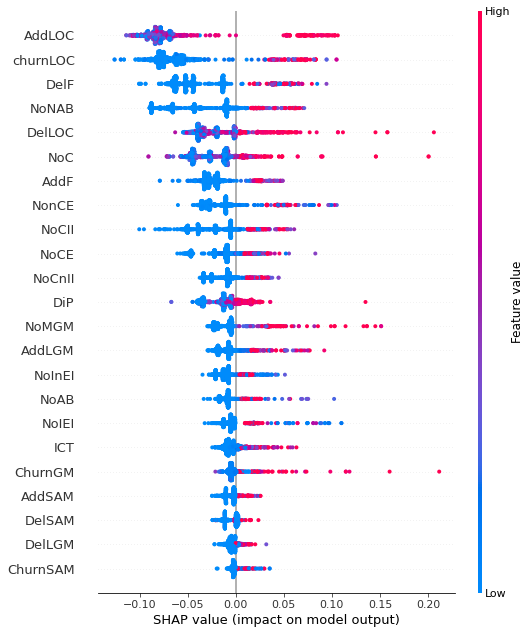

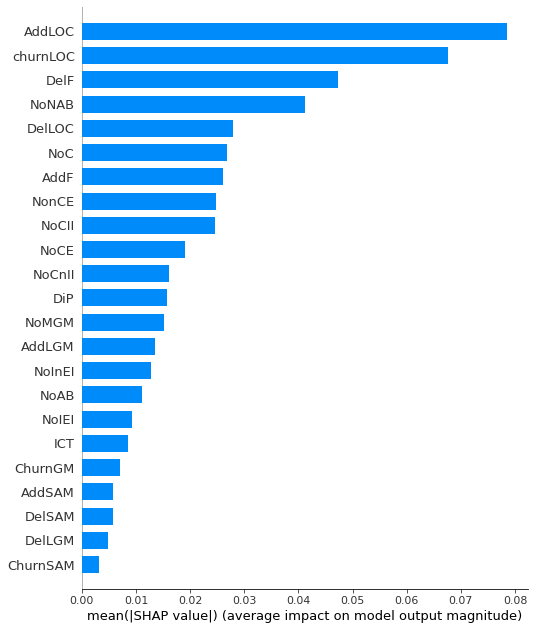

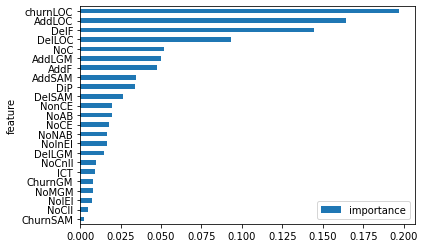

In [109]:
explain_model_with_SHAP(smote,classifier,X_scaled,y,X.columns.to_list())

          importance
feature             
NoC              3.0
NoMGM            3.0
DiP              3.0
ChurnSAM         3.0
DelSAM           3.0
AddSAM           3.0
DelF             3.0
AddF             3.0
churnLOC         3.0
DelLOC           3.0
AddLOC           3.0
ChurnGM          3.0
NoAB             3.0
DelLGM           3.0
AddLGM           3.0
NoIEI            3.0
NoInEI           3.0
NonCE            3.0
NoCE             3.0
NoCnII           3.0
NoCII            3.0
NoNAB            3.0
ICT              3.0
35.0
===> Start kfold <===
=> Fold :  1
=> Fold :  2
=> Fold :  3
=> Fold :  4
          importance
feature             
AddLOC     35.022825
AddF        3.014302
NoNAB       3.014269
NoC         3.014237
NoCnII      3.011429
NoAB        3.011396
DelF        3.008506
churnLOC    3.005731
ChurnSAM    3.005714
NoIEI       3.002857
NoCE        3.002841
NonCE       3.002841
ChurnGM     3.002841
NoMGM       3.002841
AddLGM      3.002825
DelLOC      3.000016
AddSAM      3.0000

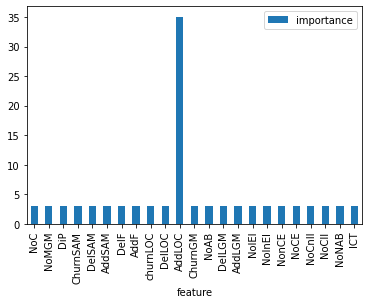

In [85]:
explain_model_with_permutation_importance(smote,classifier,X_scaled,y,X.columns.to_list())

In [2]:
smote = KMeansSMOTE(sampling_strategy='minority', random_state=9090)
classifier = KNeighborsClassifier(algorithm='ball_tree', n_neighbors=4, p=1, weights='distance')

X_synthetic, y_synthetic = smote.fit_resample(X_scaled, y)
classifier.fit(X_synthetic, y_synthetic)
pickle.dump(classifier, open("classifier_knn.pkl", 'wb'))

NameError: name 'KMeansSMOTE' is not defined

Plot confusion matrix.

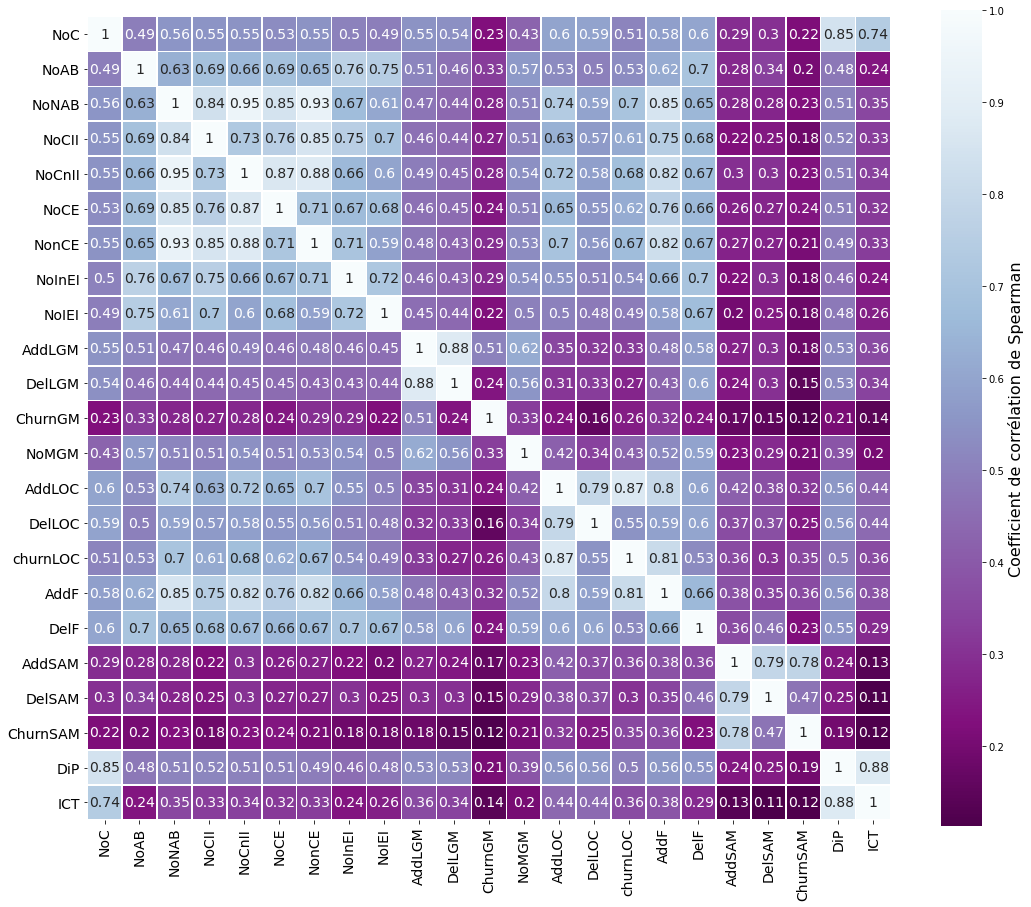

In [7]:
df = pd.read_csv("dataset_dev_anonymized.csv")
y = get_labels(df)

log_dataframe(df)
clean_dataframe(df)

fig, ax = plt.subplots(figsize=(18,15))         # Sample figsize in inches
spearman_correlations = df.corr(method='spearman')
sns.heatmap(spearman_correlations,
                xticklabels=spearman_correlations.columns,
                yticklabels=spearman_correlations.columns,
                cmap='BuPu_r',
                annot=True,
                square = True,
                linewidth=0.5, cbar_kws={'label': 'Coefficient de corrélation de Spearman'},
               annot_kws = {"size": 14})
ax.tick_params(axis='both', which='major', labelsize=14)
ax.figure.axes[-1].yaxis.label.set_size(16)


       SumAddDelLOC          DiP          NoC    SumAddDelF  SumAddDelSAM  \
count  7.030000e+02   703.000000   703.000000    703.000000    703.000000   
mean   9.327680e+03   429.071124    90.883357    126.379801     66.869132   
std    7.255702e+04   948.116242   362.277444   1032.212354    814.149058   
min    0.000000e+00     1.000000     1.000000      0.000000      0.000000   
25%    8.000000e+00     1.000000     1.000000      0.000000      0.000000   
50%    5.800000e+01     3.000000     3.000000      0.000000      0.000000   
75%    5.125000e+02   381.500000    13.000000      4.000000      0.000000   
max    1.557349e+06  6775.000000  4094.000000  19523.000000  20528.000000   

        SumAddDelSM        AddLOC         DelLOC        AddSAM       DelSAM  \
count    703.000000  7.030000e+02     703.000000    703.000000   703.000000   
mean     145.078236  7.836376e+03    1491.304410     39.049787    27.819346   
std     1141.400255  6.126235e+04   14009.693235    468.419220   352.

<AxesSubplot:>

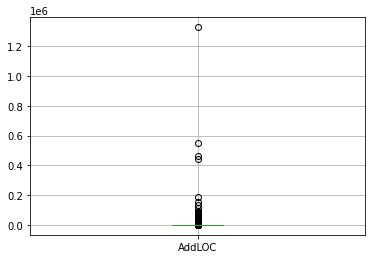

In [2]:
df = pd.read_csv("dataset_dev_anonymized.csv")
df = df[["SumAddDelLOC","DiP","NoC","SumAddDelF","SumAddDelSAM","SumAddDelSM","AddLOC","DelLOC","AddSAM","DelSAM","AddSM","DelSM"]]
df['DiP'] = df['DiP'].round()
df['DiP'].replace(0, 1, inplace=True)
print(df.describe())


